In [1]:
# local import for testing
import sys, os
sys.path.insert(1, '../src/SupplyNetPy/Components/')
import core as scm
import utilities as scm

import numpy as np
import random
import simpy
import matplotlib.pyplot as plt


INFO sim_trace - 0.0000:demand_D1:Customer0:Demand at Mumbai Warehouse, Order quantity:50, available.
INFO sim_trace - 0.0000:demand_D2:Customer0:Demand at Mumbai Warehouse, Order quantity:35, available.
INFO sim_trace - 0.9000:demand_D1:Customer0:Demand at Mumbai Warehouse, Order quantity:50 received. Current inv: 915
INFO sim_trace - 0.9000:demand_D2:Customer0:Demand at Mumbai Warehouse, Order quantity:35 received. Current inv: 915
INFO sim_trace - 1.0000:F1: Inventory levels:800
INFO sim_trace - 1.0000:F1:Replenishing raw material:raw materials mouse from supplier:S1, order placed for 1700 units. Current inventory level: {'RM1': 0}.
INFO sim_trace - 1.0000:D1: Inventory levels:915
INFO sim_trace - 1.0000:F1:shipment in transit from supplier:Supplier.
INFO sim_trace - 1.0000:demand_D2:Customer1:Demand at Mumbai Warehouse, Order quantity:35, available.
INFO sim_trace - 1.9000:demand_D2:Customer1:Demand at Mumbai Warehouse, Order quantity:35 received. Current inv: 880
INFO sim_trace - 

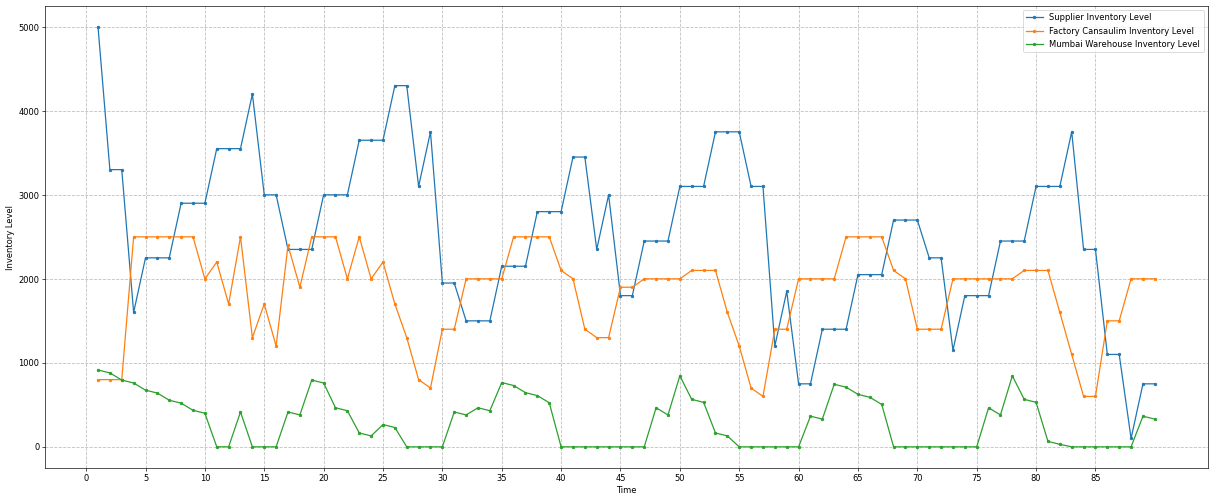

In [3]:
def print_dict(info: dict):
    for key, value in info.items():
        if type(value)==list:
            print(f"\t{key}: {len(value)} (list)")
        else:    
            print(f"\t{key}: {value}")
simtime = 90
env = simpy.Environment()
raw_mat = scm.RawMaterial(ID="RM1", name="raw materials mouse", extraction_quantity=650, 
                          extraction_time=3, mining_cost=0.01, cost=0.1) 
#supplier = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="infinite_supplier", raw_material=raw_mat)
supplier = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="supplier", raw_material=raw_mat, capacity=5000, 
                        initial_level=5000, inventory_holding_cost=0.1)
mouse = scm.Product(ID="MW11", name="Toad M11", manufacturing_cost=10, manufacturing_time=1, sell_price=300, buy_price=150,
                             raw_materials=[{"raw_material": raw_mat, "quantity": 1}], units_per_cycle=2500)
factory = scm.Manufacturer(env=env, ID='F1', name='Factory Cansaulim', capacity=2500, initial_level=800, shelf_life=10,
                           inventory_holding_cost=0.1, replenishment_policy=scm.SSReplenishment, policy_param={'s':1500, 'S':2500}, 
                           product=mouse, product_sell_price=300, inventory_type="perishable")
distributor = scm.InventoryNode(env=env, ID='D1', name='Mumbai Warehouse', node_type="warehouse", shelf_life=10,
                                capacity=1000, initial_level=1000, inventory_holding_cost=0.22,
                                replenishment_policy = scm.RQReplenishment, policy_param={'R':500, 'Q':500}, 
                                product_buy_price=300, product_sell_price=320, inventory_type="perishable")
link = scm.Link(env=env, ID='L1', source=supplier, sink=factory, cost=10, lead_time=lambda: 1)
link = scm.Link(env=env, ID='L1', source=factory, sink=distributor, cost=10, lead_time=lambda: 1)
demand1 = scm.Demand(env=env, ID='demand_D1', name='Demand Pune', order_arrival_model=lambda: 2, order_quantity_model=lambda:50, 
                     delivery_cost=lambda:10, lead_time=lambda:0.9, demand_node=distributor)
demand2 = scm.Demand(env=env, ID='demand_D2', name='Demand Kalyan', order_arrival_model=lambda: 1, order_quantity_model=lambda:35, 
                     delivery_cost=lambda:10, lead_time=lambda:0.9, demand_node=distributor)
#scm.global_logger.disable_logging()
env.run(until=simtime)
from matplotlib.pyplot import figure
figure(figsize=(25, 10), dpi=60)
for node in [supplier, factory, distributor]:
    inv_levels = np.array(node.inventory.instantaneous_levels)
    plt.plot(inv_levels[:,0], inv_levels[:,1], label=f'{node.name} Inventory Level',marker='.')
plt.xlabel('Time')
plt.ylabel('Inventory Level')
xticks = np.arange(0, simtime, 5)
plt.xticks(xticks)
plt.grid(which='both', linestyle='--', linewidth=1, alpha=0.8)
plt.legend()
plt.show()

In [4]:
total_inv_cost = 0
total_transport_cost = 0
for node in [factory, distributor]: #   demand1, demand2
    #print("info_keys = ",node._info_keys)
    #print("stats_keys = ",node._stats_keys)
    print(f"\nname:{node.name}, ID:({node.ID})")
    #print_dict(node.get_info())
    node_stats = node.get_statistics()
    print_dict(node_stats)
    total_inv_cost += node_stats['inventory_cost']
    node_transport_cost = node_stats['transportation_cost']
    total_transport_cost += sum([x[1] for x in node_transport_cost])

print(f"\nTotal Inventory Holding Cost: {total_inv_cost}")
print(f"Total Transportation Cost: {total_transport_cost}")


name:Factory Cansaulim, ID:(F1)
	node_status: active
	inventory_cost: 16640.0
	transportation_cost: 17 (list)
	node_cost: 233810.0
	profit: 150
	revenue: 4650000
	net_profit: 2091190.0
	products_sold: 500
	total_products_sold: 16000
	total_profit: 2325000
	orders_placed: 17 (list)
	orders_shortage: 9 (list)
	total_products_manufactured: 21700
	total_manufacturing_cost: 217000

name:Mumbai Warehouse, ID:(D1)
	node_status: active
	inventory_cost: 5833.300000000004
	transportation_cost: 32 (list)
	node_cost: 4656143.3
	profit: 20
	revenue: 1185600
	net_profit: -4582043.3
	products_sold: 0
	total_products_sold: 3705
	total_profit: 74100
	orders_placed: 32 (list)
	orders_shortage: 0 (list)

Total Inventory Holding Cost: 22473.300000000003
Total Transportation Cost: 490


In [6]:
# local import for testing
import sys, os
sys.path.insert(1, '../src/SupplyNetPy/Components/')
import core as scm
import utilities as scm

import numpy as np
import random
import simpy
import matplotlib.pyplot as plt


nodes = [{'ID': 'S1', 'name': 'Supplier 1', 'node_type': 'infinite_supplier'},
             {'ID': 'M1', 'name': 'Manufacturer 1', 'node_type': 'manufacturer', 'capacity': 300, 'initial_level': 200, 'inventory_holding_cost': 0.5, 'replenishment_policy': scm.SSReplenishment, 'policy_param': {'s':150,'S':300},'product_buy_price': 50,'product_sell_price': 100},
             {'ID': 'D1', 'name': 'Distributor 1', 'node_type': 'distributor', 'capacity': 150, 'initial_level': 50, 'inventory_holding_cost': 1, 'replenishment_policy': scm.SSReplenishment, 'policy_param': {'s':150,'S':300},'product_buy_price': 50,'product_sell_price': 105}
    ]

# ID, from_node, to_node, transportation_cost, lead_time
links = [{'ID': 'L1', 'source': 'S1', 'sink': 'M1', 'cost': 5, 'lead_time': lambda: 3},
            {'ID': 'L2', 'source': 'M1', 'sink': 'D1', 'cost': 5, 'lead_time': lambda: 2}
]

# ID, name, node_type, order_arrival_model, order_quantity_model, demand_node
demands = [{'ID': 'demand_D1', 'name': 'Demand 1', 'node_type': 'demand', 'order_arrival_model': lambda: 1, 'order_quantity_model': lambda: 10, 'demand_node': 'D1'}]

scm.global_logger.enable_logging()
supplychainnet = scm.create_sc_net(nodes, links, demands)
supplychainnet = scm.simulate_sc_net(supplychainnet, sim_time=50)
info_str = scm.get_sc_net_info(supplychainnet)

INFO sim_trace - 0.0000:demand_D1:Customer0:Demand at Distributor 1, Order quantity:10, available.
INFO sim_trace - 0.0000:demand_D1:Customer0:Demand at Distributor 1, Order quantity:10 received. Current inv: 40
INFO sim_trace - 1.0000:M1: Inventory levels:200
INFO sim_trace - 1.0000:D1: Inventory levels:40
INFO sim_trace - 1.0000:D1:Product not available at suppliers. Required quantity:260.
INFO sim_trace - 1.0000:demand_D1:Customer1:Demand at Distributor 1, Order quantity:10, available.
INFO sim_trace - 1.0000:demand_D1:Customer1:Demand at Distributor 1, Order quantity:10 received. Current inv: 30
INFO sim_trace - 2.0000:M1: Inventory levels:200
INFO sim_trace - 2.0000:D1: Inventory levels:30
INFO sim_trace - 2.0000:D1:Product not available at suppliers. Required quantity:270.
INFO sim_trace - 2.0000:demand_D1:Customer2:Demand at Distributor 1, Order quantity:10, available.
INFO sim_trace - 2.0000:demand_D1:Customer2:Demand at Distributor 1, Order quantity:10 received. Current inv: 2